In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"faresraslan","key":"ff7adaf88b9f075aeb18f4e76115e1be"}'}

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"faresraslan","key":"ff7adaf88b9f075aeb18f4e76115e1be"}'}

In [6]:
!pip install -q kaggle


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [8]:
!kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                     Data Science Salaries 2023 💸                       25KB  2023-04-13 09:55:16          16340        447  1.0              
chitrakumari25/corona-virus-latest-data-2023              Corona virus latest data 2023                      10KB  2023-04-29 16:00:51           1668         42  1.0              
utkarshx27/starbucks-nutrition                            Starbucks Nutrition Facts                           2KB  2023-05-10 05:42:59           1121         38  1.0              
utkarshx27/monthly-transportation-statistics              Monthly Transportation Statistics         

In [9]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:24<00:00, 95.4MB/s]
100% 2.29G/2.29G [00:24<00:00, 101MB/s] 


In [10]:
!ls
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import tensorflow as tf
import cv2



train_dir = '/content/chest_xray/chest_xray/train'
val_dir = '/content/chest_xray/chest_xray/val'
test_dir = '/content/chest_xray/chest_xray/test'


IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 200
EPOCHS = 40
hidden_layer = 200
dropout = 0.1
learinig_rate=0.001
kernal_size=[2,2]


In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)


train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
NASNetMobile = tf.keras.applications.NASNetMobile(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes= 2
)

NASNetMobile.trainable = False



19993432/19993432 [==============================] - 0s 0us/step


In [14]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = NASNetMobile(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 dense (Dense)               (None, 1024)              1082368   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 5,353,109
Trainable params: 1,083,393
Non-trainable params: 4,269,716
_________________________________________________________________
None


In [15]:


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [16]:
 history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

     callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]

    
)

Epoch 1/40
27/27 [==============================] - 599s 21s/step - loss: 0.4878 - accuracy: 0.8046 - auc: 0.8312 - val_loss: 0.8825 - val_accuracy: 0.5625 - val_auc: 0.9219
Epoch 2/40
27/27 [==============================] - 550s 20s/step - loss: 0.2030 - accuracy: 0.9201 - auc: 0.9671 - val_loss: 0.8201 - val_accuracy: 0.6250 - val_auc: 0.9453
Epoch 3/40
27/27 [==============================] - 540s 20s/step - loss: 0.1792 - accuracy: 0.9302 - auc: 0.9739 - val_loss: 0.1914 - val_accuracy: 0.9375 - val_auc: 0.9844
Epoch 4/40
27/27 [==============================] - 534s 20s/step - loss: 0.1744 - accuracy: 0.9314 - auc: 0.9747 - val_loss: 0.5387 - val_accuracy: 0.8125 - val_auc: 0.9141
Epoch 5/40
27/27 [==============================] - 517s 19s/step - loss: 0.1430 - accuracy: 0.9457 - auc: 0.9830 - val_loss: 0.4739 - val_accuracy: 0.8125 - val_auc: 0.9688
Epoch 6/40
27/27 [==============================] - 514s 19s/step - loss: 0.1318 - accuracy: 0.9484 - auc: 0.9862 - val_loss: 0.70

In [17]:
model.save('NasNetMobile.h5')

In [18]:

new_model=keras.models.load_model("NasNetMobile.h5")


In [19]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 dense (Dense)               (None, 1024)              1082368   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 5,353,109
Trainable params: 1,083,393
Non-trainable params: 4,269,716
_________________________________________________________________


In [20]:

true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

print(pred_labels)

4/4 [==============================] - 69s 13s/step
[1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0
 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0
 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1

<ipython-input-20-8dedd8ff62b4>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))


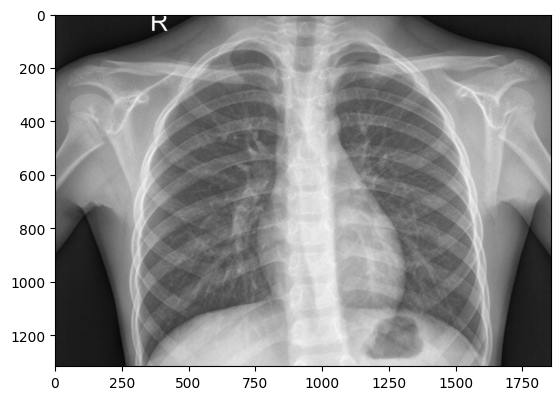

In [ ]:


x=cv2.imread('/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

plt.imshow(x)

In [ ]:
x.shape

(1317, 1857, 3)

In [ ]:
x=cv2.resize(x,(224,224))
x.shape

(224, 224, 3)

In [ ]:
#predict normal image
x='/content/test'

test_dataa = train_datagen.flow_from_directory(
    x,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

pred_labelss = np.squeeze(np.array(model.predict(test_dataa) >= 0.5, dtype=np.int))
print("-------------------------------  NORMAL  ---------------------------------")
print(pred_labelss)


Found 234 images belonging to 3 classes.
2/2 [==============================] - 6s 890ms/step
-------------------------------  NORMAL  ---------------------------------
[1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0
 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0
 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 1 0 1 1 0 1 1 1 0 0]


<ipython-input-33-f80c51463fba>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labelss = np.squeeze(np.array(model.predict(test_dataa) >= 0.5, dtype=np.int))


In [ ]:
#predict PNEUMONIA image
x='/content/test'

test_dataa = train_datagen.flow_from_directory(
    x,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

pred_labelss = np.squeeze(np.array(model.predict(test_dataa) >= 0.5, dtype=np.int))
print("-------------------------------  PNEUMONIA  ---------------------------------")
print(pred_labelss)


Found 390 images belonging to 3 classes.
2/2 [==============================] - 9s 6s/step
-------------------------------  PNEUMONIA  ---------------------------------
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


<ipython-input-34-1a24645bc229>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labelss = np.squeeze(np.array(model.predict(test_dataa) >= 0.5, dtype=np.int))


In [ ]:
img='/content/test'

test_dataa = train_datagen.flow_from_directory(
    img,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)
pred_labelss = np.squeeze(np.array(model.predict(test_dataa) >= 0.5, dtype=np.int))

if pred_labelss==0:
  print("normal")
else:
    print("you have corona ")

Found 1 images belonging to 3 classes.
1/1 [==============================] - 0s 110ms/step
normal


<ipython-input-51-fa4d59b422ec>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labelss = np.squeeze(np.array(model.predict(test_dataa) >= 0.5, dtype=np.int))


In [21]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

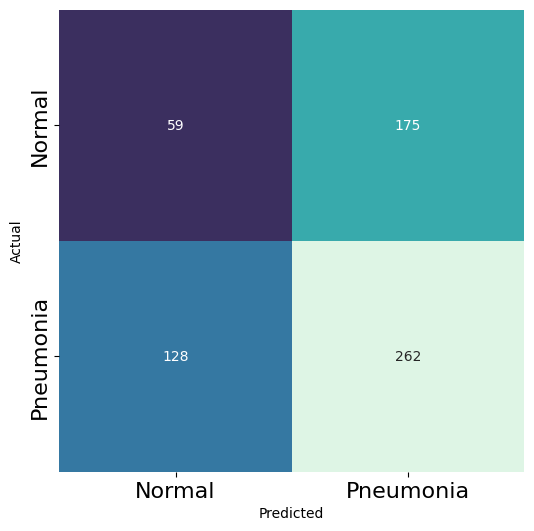

In [22]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [23]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [29]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

f1 = 2* tp / (2* tp + fp + fn)

NPV = tn /(tn + fn) 
Specificity = tn /(tn + fp)

In [30]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))
print("NPV: {:.2f}".format(NPV))
print("Specificity: {:.2f}".format(Specificity))

Accuracy: 0.85
AUC: 0.93
Precision: 0.60
Recall: 0.67
F1 score: 0.63
NPV: 0.32
Specificity: 0.25


In [ ]:
# precision tp / (tp + fp)

# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(testy, yhat_classes)
#print('F1 score: %f' % f1)

In [ ]:
print("F1 score: {:.2f}".format(f1))

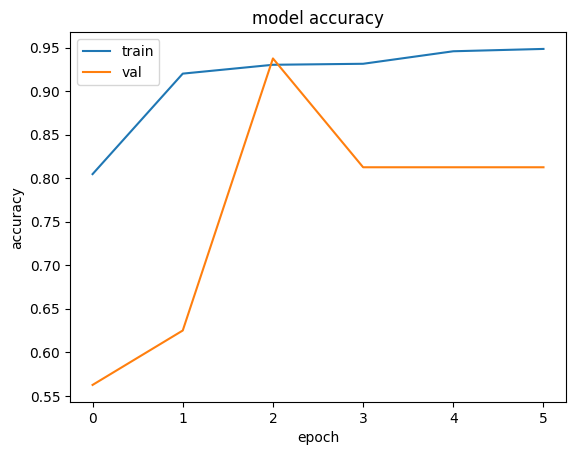

In [26]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

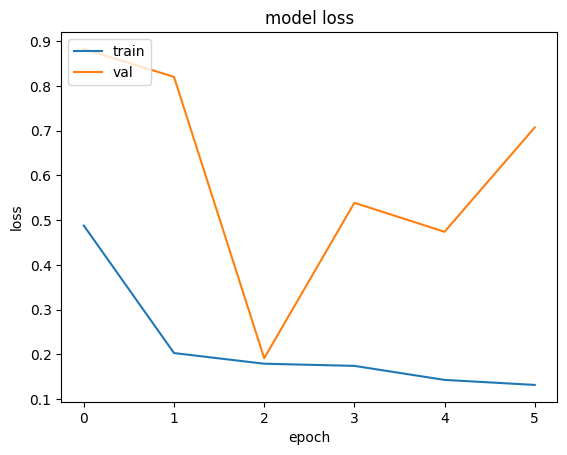

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="val accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()